In [1]:
!pip install -U transformers datasets evaluate accelerate trl peft bitsandbytes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 20.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 30.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.9/133.9 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.3/168.3 kB 16.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.6/92.6 MB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.9/100.9 kB 3.6 MB/s eta 0:00:00
  Attempting uninstall: transformers
    Found existing installation: transformers 4.35.2
    Uninstalling transformers-4.35.2:
      Successfully uninstalled transformers-4.35.2


In [2]:
import pandas as pd
import torch
from datasets import Dataset, DatasetDict
from peft import LoraConfig, get_peft_model, prepare_model_for_kbit_training
from tqdm.auto import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, BitsAndBytesConfig, TrainingArguments, Trainer, DataCollatorWithPadding
import evaluate
import numpy as np
import bitsandbytes
from sklearn.metrics import precision_score, recall_score, f1_score
import math
import seaborn as sns

tqdm.pandas()
try:
    from google.colab import drive
    drive.mount('/content/gdrive')

    DATA_PATH = '/content/gdrive/MyDrive/CSI5137-project/data/'
    model_name = 'kwang123/llama2-7B-ReqORNot'
except:
    DATA_PATH = 'data/'
    model_name = '7B-hf'

device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")
device

Mounted at /content/gdrive


<ipython-input-2-423dbb374ab4>:25: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  device = torch.device("mps" if getattr(torch,'has_mps',False) else "cuda:0" if torch.cuda.is_available() else "cpu")


device(type='cuda', index=0)

## Load Data

In [3]:
# Load PURE dataset
pure = pd.read_csv(DATA_PATH + 'PURE_test.csv')

pure['Req/Not Req'] = pure['Req/Not Req'].apply(lambda x: 1 if x == 'Req' else 0)

pure['text'] = pure['Requirement']
pure['label'] = pure['Req/Not Req']
pure = pure.drop(['Unnamed: 0', 'Name of Doc', 'Requirement', 'Req/Not Req'], axis=1)

pure = pure.sample(frac=1).reset_index(drop=True)

print(pure['label'].value_counts())
pure.head(10)

1    1058
0     476
Name: label, dtype: int64


,text,label
0,The utility timer shall (3.3.10.25) have a res...,1
1,This document provides a high-level statement ...,0
2,A DH Technician is responsible for setting up ...,0
3,The NE shall (3.2.3.2.3) support at least 6 vi...,1
4,DSS - Decision Support System.,0
5,The interrupts across all channels shall (3.4....,1
6,The group considered functionality of software...,0
7,Monitors and ensures that AIPs are not corrupt...,1
8,“Pavement data” in this context includes surfa...,0
9,The owner is then able to set up subsidiary us...,1


In [4]:
dronology = pd.read_csv(DATA_PATH + 'dronology_five_folds/fold_1/test_fold_1.csv')

for i in range(2, 6):
    tmp_test = pd.read_csv(DATA_PATH + 'dronology_five_folds/fold_{}/test_fold_{}.csv'.format(i, i))
    dronology = pd.concat([dronology, tmp_test], axis=0)

dronology['text'] = dronology['STR.REQ']
dronology['label'] = dronology['class']
dronology = dronology.drop(['issueid', 'STR.REQ', 'class'], axis=1)

dronology = dronology.drop_duplicates(subset=["text"], keep="first")

print(dronology['label'].value_counts())
dronology.head(10)

0    278
1     99
Name: label, dtype: int64


,text,label
0,The GCS shall assign a message frequency for a...,1
1,The RealTimeFlightUI shall display all current...,1
2,The RealTimeFlightUI shall display the name an...,1
3,When requested the RouteCreationUI shall send ...,1
4,The ActivityLogger shall log all commands sent...,1
5,When a UAV is deactivated the UAVActivationMan...,1
6,If requested the SingleUAVFlightPlanScheduler ...,1
7,If a flight route is assigned to a UAV which i...,1
8,When given two coordinates the CoordinateSyste...,1
9,The FlightRouteManager shall define flight rou...,1


1852


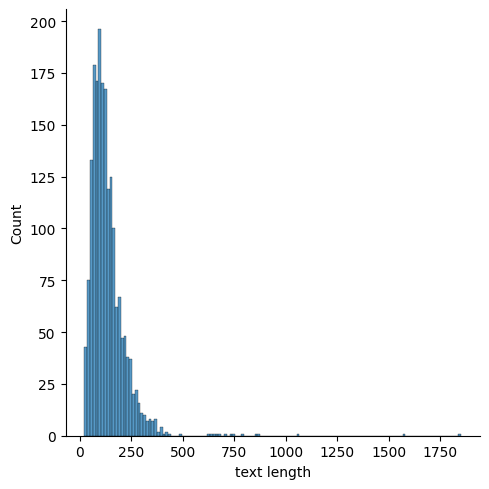

In [5]:
test = pd.concat([pure, dronology], axis=0)
test['text length'] = test['text'].apply(len)
print(max(test['text length']))
sns.displot(test, x='text length')

test = test.drop(['text length'], axis=1)

In [6]:
data = Dataset.from_pandas(test)
data

Dataset({
    features: ['text', 'label', '__index_level_0__'],
    num_rows: 1911
})

## Pre-processing Data

In [7]:
# TODO: add your huggingface access token for Llama2 model
token = ''
tokenizer = AutoTokenizer.from_pretrained(model_name, token=token)
tokenizer.pad_token = tokenizer.eos_token

def preprocessing_func(examples):
    return tokenizer(examples['text'], max_length=4096, truncation=True)

tokenized_data = data.map(preprocessing_func, batched=True, remove_columns=['text', '__index_level_0__'])

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

tokenized_data

tokenizer_config.json:   0%|          | 0.00/920 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/437 [00:00<?, ?B/s]

Map:   0%|          | 0/1911 [00:00<?, ? examples/s]

Dataset({
    features: ['label', 'input_ids', 'attention_mask'],
    num_rows: 1911
})

## Load Model

In [8]:
quantization_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# TODO: add your huggingface access token for Llama2 model
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    quantization_config=quantization_config,
    device_map='auto',
    torch_dtype=torch.bfloat16,
    token='',
    num_labels=2,
)

adapter_config.json:   0%|          | 0.00/652 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at meta-llama/Llama-2-7b-hf and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


adapter_model.safetensors:   0%|          | 0.00/640M [00:00<?, ?B/s]

## Inference

In [11]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    matrics = accuracy.compute(predictions=predictions, references=labels)

    matrics['weighted precision'] = precision_score(labels, predictions, average='weighted')
    matrics['weighted recall'] = recall_score(labels, predictions, average='weighted')
    matrics['weighted f1'] = f1_score(labels, predictions, average='weighted')

    matrics['macro precision'] = precision_score(labels, predictions, average='macro')
    matrics['macro recall'] = recall_score(labels, predictions, average='macro')
    matrics['macro f1'] = f1_score(labels, predictions, average='macro')
    return matrics

In [12]:
# model = load_model(model_name)

model.config.pad_token_id = model.config.eos_token_id

trainer = Trainer(
    model=model,
    eval_dataset=tokenized_data,
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

model.config.use_cache = False

trainer.evaluate(tokenized_data)

{'eval_loss': 0.14043253660202026,
 'eval_accuracy': 0.9445316588173731,
 'eval_weighted precision': 0.9456365497677746,
 'eval_weighted recall': 0.9445316588173731,
 'eval_weighted f1': 0.9447400180395412,
 'eval_macro precision': 0.9394522295870549,
 'eval_macro recall': 0.9461076505826602,
 'eval_macro f1': 0.9424075523024924,
 'eval_runtime': 206.3813,
 'eval_samples_per_second': 9.26,
 'eval_steps_per_second': 1.158}